In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, exc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///C://Users//atvar//OneDrive//Documents//Bootcamp//May_Homework//10-SQLAlchemy_Homework//Resources//hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Show first row of data in Measurement table to see columns.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x221f4f7d6d8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

Text(0, 0.5, 'Inches')

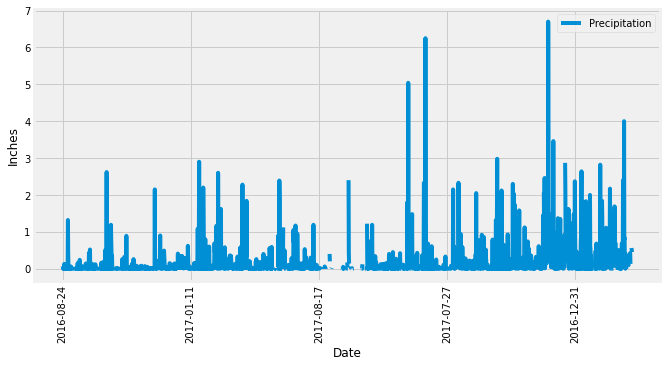

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
start_date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= end_date).filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Dataframe is already sorted by date from query.
precip_df = pd.DataFrame(precip_scores, columns=['Date', 'Precipitation'])


# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(x='Date', y='Precipitation', rot=90, figsize=(10,5))
ax.set_ylabel('Inches')

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Print out first row to get column names.
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x221f5376b38>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [15]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(func.count(Station.station)).all()
stations_count

[(9)]

In [16]:
# Create initial dataframe with stations.
active_stations = session.query(Station.station).group_by(Station.station).all()
active_stations_df = pd.DataFrame(active_stations, columns=['Station'])
active_stations_df

,Station
0,USC00511918
1,USC00513117
2,USC00514830
3,USC00516128
4,USC00517948
5,USC00518838
6,USC00519281
7,USC00519397
8,USC00519523


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# Create list with station names from the above dataframe.
stations = ['USC00511918', 'USC00513117', 'USC00514830', 'USC00516128', 'USC00517948', 'USC00518838',
           'USC00519281', 'USC00519397', 'USC00519523']
# Create empty list for station count.
station_count = []
# Use for loop to find the count for each station in the stations list.
for station in stations:
    current_count = session.query(Measurement.station).filter(Measurement.station == station).count()
    station_count.append(current_count)
# Print station count to verify the loop worked.
station_count

[1979, 2709, 2202, 2612, 1372, 511, 2772, 2724, 2669]

In [18]:
# Add station count to existing dataframe.
active_stations_df['Count'] = station_count
# List the stations and the counts in descending order.
active_stations_df = active_stations_df.sort_values(by='Count', ascending=False)
active_stations_df

,Station,Count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Create list of measurements to find in the query.
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

# Create query.
most_active = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

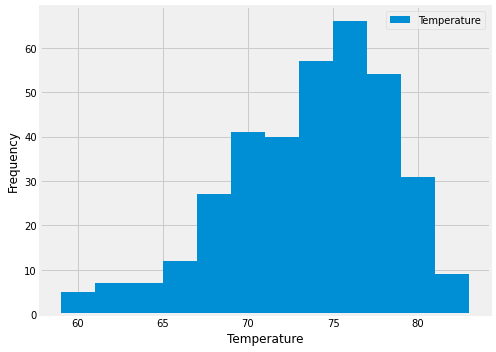

In [20]:
# Using the most active station id,
# query the last 12 months of temperature observation data for this station and plot the results as a histogram.

# Get most recent date for the most active station.
station_most_recent = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()
station_end_date = dt.datetime(2017, 8, 18)
# Get the date for 12 months prior to the most recent date.
station_start_date = dt.datetime(2016, 8, 18)

# Create query to get temperature data for the most active station.
tobs_data = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date <= station_end_date).filter(Measurement.date >= station_start_date).all()

# Create dataframe to plot histogram.
tobs_df = pd.DataFrame(tobs_data, columns=['Station', 'Temperature'])

# Plot histogram.
ax = tobs_df.plot.hist(bins=12, figsize=(7,5))
ax.set_xlabel('Temperature')
plt.tight_layout()
plt.show()

# Close session

In [21]:
# Close Session
session.close()